In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b50dtxt/glove.6B.50d.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
train.shape

(7613, 5)

In [6]:
from nltk.corpus import stopwords
import nltk, os, re, string
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

train['text']=train['text'].apply(remove_stopwords)
test['text']=test['text'].apply(remove_stopwords)

In [7]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,"Heard #earthquake different cities, stay safe ..."
2,3,NaN,NaN,"forest fire spot pond, geese fleeing across st..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 China Taiwan


In [8]:
import nltk
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords

lemma = WordNetLemmatizer()
def process_text(text):
    text = re.sub("(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])", " ",text.lower())
    words = nltk.word_tokenize(text)
    words = [lemma.lemmatize(word) for word in words if word not in set(stopwords.words("english"))]
    text = " ".join(words)
        
    return text

train["text"] = train["text"].apply(process_text)
test["text"] = test["text"].apply(process_text)

In [9]:
import emoji

def cleanTweet(txt):
    txt = re.sub(r'#','',txt)
    txt = re.sub(r'RT : ','',txt)
    txt = re.sub(r'\n','',txt)
    # to remove emojis
    txt = re.sub(emoji.get_emoji_regexp(), r"", txt)
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+','',txt)
    txt = re.sub(r"https?://\S+|www\.\S+","",txt)
    txt = re.sub(r"<.*?>","",txt)
    return txt  

In [10]:
train["text"] = train["text"].apply(cleanTweet)
test["text"] = test["text"].apply(cleanTweet)

In [11]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1
3,6,NaN,NaN,13 000 people receive wildfire evacuation orde...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1


In [12]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different city stay safe ever...
2,3,NaN,NaN,forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfire
4,11,NaN,NaN,typhoon soudelor kill 28 china taiwan


In [13]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [14]:
train["length"] = train["text"].apply(len)

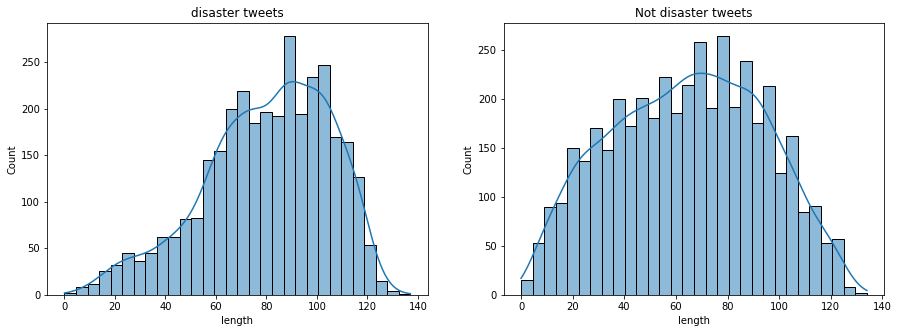

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
sns.histplot(train[train["target"] == 1]["length"],bins = 30,ax = ax1, kde=True).set(title = "disaster tweets")
sns.histplot(train[train["target"] == 0]["length"],bins = 30,ax = ax2, kde = True).set(title = "Not disaster tweets")
plt.show()

In [16]:
train_disaster = train[train["target"] == 1]
train_not_disaster  = train[train["target"] == 0]

In [17]:
train_disaster.length.describe()

count    3271.000000
mean       80.237542
std        24.947385
min         0.000000
25%        64.000000
50%        84.000000
75%       100.000000
max       137.000000
Name: length, dtype: float64

In [18]:
train_not_disaster.length.describe()

count    4342.000000
mean       64.320129
std        29.237484
min         0.000000
25%        41.000000
50%        65.000000
75%        88.000000
max       134.000000
Name: length, dtype: float64

In [19]:
path = '/kaggle/input/'
EMBEDDING_FILE=f'{path}glove6b50dtxt/glove.6B.50d.txt'

# configuration setting
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64
EPOCHS = 5

In [20]:
from sklearn.model_selection import train_test_split
X, y = train['text'], train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(EMBEDDING_FILE) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [22]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(list(X_train))

# pad sequences so that we get a N x T matrix
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train.shape)

Shape of data tensor: (6090, 100)


In [23]:
X_test = tokenizer.texts_to_sequences(list(X_test))

# pad sequences so that we get a N x T matrix
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)

Shape of data tensor: (1523, 100)


In [24]:
test = tokenizer.texts_to_sequences(list(test['text']))

# pad sequences so that we get a N x T matrix
test = pad_sequences(test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', test.shape)

Shape of data tensor: (3263, 100)


In [25]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 15471 unique tokens.


In [26]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [27]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [28]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy']
)
model.summary()

Building model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 50)           773600    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 30)           7920      
_________________________________________________________________
global_max_pooling1d (Global (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 781,551
Trainable params: 7,951
Non-trainable params: 773,600
_________________________________________________________________


In [29]:
print('Training model...')
r = model.fit(
  X_train,
  y_train,
  batch_size=BATCH_SIZE,
  epochs=50,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/50
77/77 [==============================] - 8s 61ms/step - loss: 0.5355 - accuracy: 0.7488 - val_loss: 0.4811 - val_accuracy: 0.7701
Epoch 2/50
77/77 [==============================] - 4s 46ms/step - loss: 0.4180 - accuracy: 0.8119 - val_loss: 0.4728 - val_accuracy: 0.7865
Epoch 3/50
77/77 [==============================] - 4s 46ms/step - loss: 0.3791 - accuracy: 0.8365 - val_loss: 0.4701 - val_accuracy: 0.7923
Epoch 4/50
77/77 [==============================] - 3s 45ms/step - loss: 0.3397 - accuracy: 0.8535 - val_loss: 0.4928 - val_accuracy: 0.7775
Epoch 5/50
77/77 [==============================] - 4s 46ms/step - loss: 0.3112 - accuracy: 0.8694 - val_loss: 0.5082 - val_accuracy: 0.7874
Epoch 6/50
77/77 [==============================] - 4s 48ms/step - loss: 0.2913 - accuracy: 0.8797 - val_loss: 0.5380 - val_accuracy: 0.7800
Epoch 7/50
77/77 [==============================] - 3s 45ms/step - loss: 0.2577 - accuracy: 0.8943 - val_loss: 0.5438 - val_accuracy: 0.

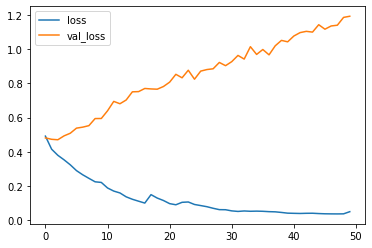

In [30]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

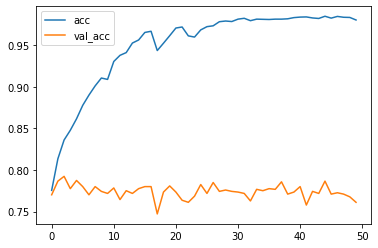

In [31]:
# Plotting accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [32]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

191/191 [==============================] - 2s 12ms/step - loss: 0.3007 - accuracy: 0.9266
Accuracy of the model on Training Data is -  92.6600992679596
48/48 [==============================] - 1s 11ms/step - loss: 1.0735 - accuracy: 0.7584
Accuracy of the model on Testing Data is -  75.8371651172638


In [33]:
pred = model.predict(X_test)
pred[:5]

array([[0.6229027 ],
       [0.11763141],
       [0.7200059 ],
       [0.0117639 ],
       [0.78144026]], dtype=float32)

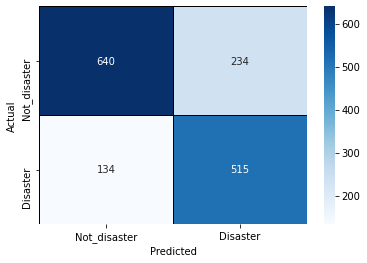

In [34]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

cm = confusion_matrix(y_test,pred.round())
cm = pd.DataFrame(cm , index = ['Not_disaster','Disaster'] , columns = ['Not_disaster','Disaster'])
plt.figure(figsize = (6,4))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not_disaster','Disaster'] , yticklabels = ['Not_disaster','Disaster'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [35]:
print(classification_report(y_test,pred.round()))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78       874
           1       0.69      0.79      0.74       649

    accuracy                           0.76      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.77      0.76      0.76      1523



In [36]:
predictions_test = model.predict(test)
predictions_test[:5]

array([[0.99967045],
       [0.99998283],
       [0.9998724 ],
       [0.9933909 ],
       [1.        ]], dtype=float32)

In [37]:
submission_sample = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission_sample.head()
submission_sample.shape

(3263, 2)

In [38]:
predicted_value = (predictions_test > 0.5).astype(int)
submission_sample.target = predicted_value
submission_sample.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [39]:
submission_sample.to_csv('submission_3.csv',index=False)